# Verify unpacking BB mode files from EK80

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from echopype.convert import Convert
from echopype.convert.ek80 import ConvertEK80
from echopype.model import EchoData

In [2]:
ek80_raw_path = './echopype/test_data/ek80/D20170912-T234910.raw'

In [3]:
ek80_bb_power_test_path = './echopype/test_data/ek80/from_echoview/45-90kHz.complex.csv'

In [4]:
tmp = ConvertEK80(ek80_raw_path)
tmp.raw2nc()

          ... this file has already been converted to .nc, conversion not executed.


## Verify parsing output

Here we compare the parsing outputs with those parsed from Chu's Matlab code _before pulse compression_. Note that we can't compare with EchoView outputs at this stage since EchoView record outputs after pulse compression.

In [5]:
ds_beam = xr.open_dataset(ek80_raw_path[:-4]+'.nc', group='Beam')

In [6]:
ds_beam.sel(frequency=70000)

<xarray.Dataset>
Dimensions:                         (ping_time: 88, quadrant: 4, range_bin: 25229)
Coordinates:
    frequency                       float32 70000.0
  * ping_time                       (ping_time) float64 3.714e+09 ... 3.714e+09
    frequency_start                 int64 ...
    frequency_end                   int64 ...
  * quadrant                        (quadrant) int64 0 1 2 3
  * range_bin                       (range_bin) int64 0 1 2 ... 25227 25228
Data variables:
    channel_id                      object ...
    beamwidth_receive_alongship     float32 ...
    beamwidth_receive_athwartship   float32 ...
    beamwidth_transmit_alongship    float32 ...
    beamwidth_transmit_athwartship  float32 ...
    beam_direction_x                float32 ...
    beam_direction_y                float32 ...
    beam_direction_z                float32 ...
    angle_offset_alongship          float32 ...
    angle_offset_athwartship        float32 ...
    angle_sensitivity_alongship     float32 ...
    angle_sensitivity_athwartship   float32 ...
    equivalent_beam_angle           float32 ...
    gain_correction                 float32 ...
    sample_interval                 float32 ...
    transmit_bandwidth              float32 ...
    transmit_duration_nominal       float32 ...
    transmit_power                  float32 ...
    transducer_offset_x             float32 ...
    transducer_offset_y             float32 ...
    transducer_offset_z             float32 ...
    slope                           (ping_time) float64 ...
    backscatter_r                   (quadrant, ping_time, range_bin) float32 ...
    backscatter_i                   (quadrant, ping_time, range_bin) float32 ...
    gpt_software_version            object ...
    sa_correction                   float64 ...

In [7]:
# Get real dimension of range_bin (i.e., remove NaN entries)
ds_beam.sel(frequency=70000).isel(quadrant=0,ping_time=0)['backscatter_r'].dropna('range_bin').shape

(8410,)

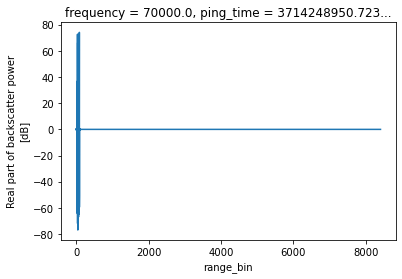

In [8]:
ds_beam.sel(frequency=70000).isel(quadrant=0,ping_time=0)['backscatter_r'].dropna('range_bin').plot()

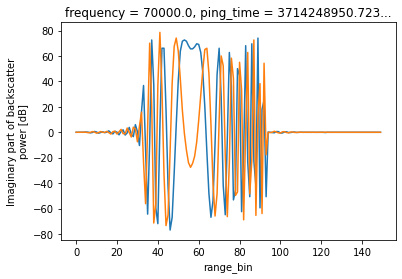

In [9]:
# Ping 0
ds_beam.sel(frequency=70000).isel(ping_time=0,range_bin=slice(0,150),quadrant=0)['backscatter_r'].\
    dropna('range_bin').plot()
ds_beam.sel(frequency=70000).isel(ping_time=0,range_bin=slice(0,150),quadrant=0)['backscatter_i'].\
    dropna('range_bin').plot()

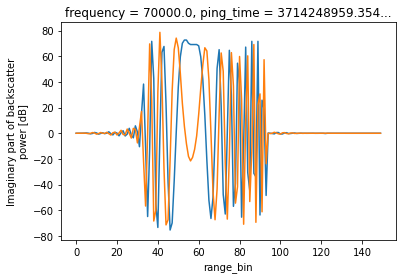

In [10]:
# Ping 10
ds_beam.sel(frequency=70000).isel(ping_time=10,range_bin=slice(0,150),quadrant=0)['backscatter_r'].\
    dropna('range_bin').plot()
ds_beam.sel(frequency=70000).isel(ping_time=10,range_bin=slice(0,150),quadrant=0)['backscatter_i'].\
    dropna('range_bin').plot()

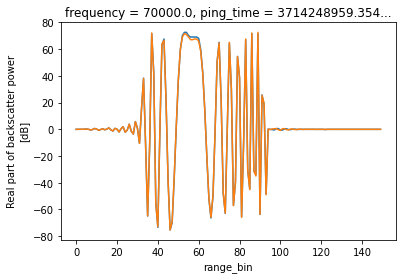

In [11]:
# Ping 10, quadrant 1 and 4
ds_beam.sel(frequency=70000).isel(ping_time=10,range_bin=slice(0,150),quadrant=0)['backscatter_r'].\
    dropna('range_bin').plot()
ds_beam.sel(frequency=70000).isel(ping_time=10,range_bin=slice(0,150),quadrant=3)['backscatter_r'].\
    dropna('range_bin').plot()

The above results are visually identical to outputs from Matlab code:
```~matlab
>> data = EK80readRawFiles_rev(rawfiles, para.minRange, para.maxRange,'V3')

% Ping 0, real and imag parts
>> D70k = data.echodata(1,1).complexsamples;
>> figure
>> plot(real(D70k(:,1)))
>> hold on
>> plot(imag(D70k(:,1)))
>> xlim([0,150])

% Ping 10, real and imag parts
>> D70k = data.echodata(1,11).complexsamples;
>> figure
>> plot(real(D70k(:,1)))
>> hold on
>> plot(imag(D70k(:,1)))
>> xlim([0,150])

% Ping 10, quadrant 1 and 4, real part
>> D70k = data.echodata(1,11).complexsamples;
>> figure
>> plot(real(D70k(:,1)))
>> hold on
>> plot(real(D70k(:,4)))
>> xlim([0,150])
```

The values are also verified below (note the Matlab code discard the first sample, so we start at sample number=1 instead of 0):

In [12]:
ds_beam.sel(frequency=70000).isel(ping_time=10,range_bin=slice(0,11),quadrant=0)['backscatter_r'].values[1:]

array([-1.7568245e-04, -4.6453513e-03, -9.0769464e-03,  7.9211913e-02,
        2.3850445e-01,  4.1802455e-02, -4.4283006e-01, -1.6086248e-01,
        6.3761616e-01,  2.5629508e-01], dtype=float32)

In [13]:
ds_beam.sel(frequency=70000).isel(ping_time=10,range_bin=slice(0,11),quadrant=0)['backscatter_i'].values[1:]

array([ 3.7520481e-04,  1.9356719e-03,  3.3990372e-02,  1.0704432e-01,
       -2.6821198e-02, -3.3345452e-01, -1.0728649e-01,  5.4386514e-01,
        2.1799137e-01, -6.9816238e-01], dtype=float32)

## Load data exported by EchoView

In [14]:
# Load all data
df = pd.read_csv(ek80_bb_power_test_path, header=None, skiprows=[0])

In [15]:
# Get header only
df_header = pd.read_csv(ek80_bb_power_test_path, header=0, usecols=range(14), nrows=0)
df_header

,Ping_index,Component,Distance_gps,Distance_vl,Ping_date,Ping_time,Ping_milliseconds,Latitude,Longitude,Depth_start,Depth_stop,Range_start,Range_stop,Sample_count


In [16]:
# Reset column names
df = df.rename(columns={ cc : vv for cc,vv in zip(df.columns, df_header.columns.values) })

In [17]:
df.columns = df.columns.str.strip()  # remove leading or trailing space (' ') in column name

In [18]:
df

,Ping_index,Component,Distance_gps,Distance_vl,Ping_date,Ping_time,Ping_milliseconds,Latitude,Longitude,Depth_start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,Real,0.000000,9361.098000,2017-09-12,23:49:10,723.0,999.000000,999.000000,-0.005946,...,-3.628869e-10,-1.482831e-10,3.452665e-10,2.782871e-10,-8.292638e-11,-2.152297e-10,-1.046148e-10,-1.362034e-11,3.246335e-13,-2.815433e-22
1,0,Imaginary,0.000000,9361.098000,2017-09-12,23:49:10,723.0,999.000000,999.000000,-0.005946,...,-3.451360e-10,2.160503e-10,8.825239e-11,-3.955777e-10,-4.784054e-10,-2.250294e-10,-3.601112e-11,5.026210e-12,-2.817627e-13,-1.126173e-22
2,1,Real,0.000000,9361.098102,2017-09-12,23:49:12,253.0,47.623278,-122.404365,-0.005946,...,-7.438625e-10,1.058628e-09,4.933991e-10,-4.414399e-10,-2.874594e-10,3.299962e-11,4.133994e-11,2.556680e-12,-4.975038e-14,-5.208551e-22
3,1,Imaginary,0.000000,9361.098102,2017-09-12,23:49:12,253.0,47.623278,-122.404365,-0.005946,...,1.553165e-09,6.109745e-10,-7.856552e-10,-4.557498e-10,1.692783e-10,1.503424e-10,9.712809e-12,-3.298449e-12,1.140912e-13,1.689260e-22
4,2,Real,0.000049,9361.098155,2017-09-12,23:49:13,43.0,47.623278,-122.404364,-0.005946,...,1.093050e-10,-3.775569e-10,-6.700188e-11,4.081179e-11,-1.904739e-10,-1.792336e-10,-3.769641e-11,4.853900e-12,-2.374509e-13,8.164756e-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,85,Imaginary,0.006516,9361.102556,2017-09-12,23:50:18,896.0,47.623239,-122.404234,-0.005946,...,1.896300e-09,7.342896e-10,-1.051002e-09,-5.080624e-10,3.834608e-10,2.997284e-10,3.366404e-11,-8.374692e-12,3.369866e-13,-8.446299e-23
172,86,Real,0.006636,9361.102609,2017-09-12,23:50:19,686.0,47.623237,-122.404232,-0.005946,...,-8.016767e-10,6.493319e-10,8.161178e-10,-8.604333e-11,-3.310301e-10,-2.543730e-11,6.740499e-11,1.230732e-11,-3.118957e-13,4.504693e-22
173,86,Imaginary,0.006636,9361.102609,2017-09-12,23:50:19,686.0,47.623237,-122.404232,-0.005946,...,8.325206e-10,8.665459e-10,-4.013434e-10,-6.131057e-10,9.980922e-12,2.057551e-10,6.043652e-11,-2.636931e-12,1.841586e-13,-4.504693e-22
174,87,Real,0.006769,9361.102662,2017-09-12,23:50:20,476.0,999.000000,999.000000,-0.005946,...,-3.154170e-10,-1.107871e-09,1.161382e-11,5.089839e-10,9.227074e-11,-1.456805e-10,-6.503079e-11,-2.454392e-12,-2.817478e-14,2.393118e-22


In [19]:
df_real = df.iloc[::2,14:].transpose()
df_real.index = range(8410)
df_real

,0,2,4,6,8,10,12,14,16,18,...,156,158,160,162,164,166,168,170,172,174
0,-6.777667e+01,-6.774009e+01,-6.704103e+01,-6.783346e+01,-6.772696e+01,-6.782665e+01,-6.775647e+01,-6.770116e+01,-6.726868e+01,-6.769905e+01,...,-6.776772e+01,-6.719675e+01,-6.721443e+01,-6.781846e+01,-6.769333e+01,-6.570169e+01,-6.771594e+01,-6.777426e+01,-6.775638e+01,-6.776876e+01
1,-3.689998e+01,-3.687235e+01,-3.177401e+01,-3.692464e+01,-3.444198e+01,-3.692419e+01,-3.446601e+01,-3.442884e+01,-3.911907e+01,-3.443556e+01,...,-3.688403e+01,-3.908034e+01,-3.909459e+01,-3.691515e+01,-3.443086e+01,-2.889367e+01,-3.444168e+01,-3.691304e+01,-3.688723e+01,-3.688711e+01
2,4.866761e+00,4.868585e+00,2.720294e+00,4.877091e+00,3.829254e+00,4.862848e+00,3.844253e+00,3.835262e+00,5.683669e+00,3.827034e+00,...,4.863535e+00,5.689395e+00,5.667127e+00,4.878349e+00,3.829351e+00,1.606222e+00,3.836205e+00,4.861036e+00,4.864546e+00,4.864470e+00
3,1.181920e+00,1.178314e+00,-2.775528e-01,1.185192e+00,4.232521e-01,1.179733e+00,4.303837e-01,4.153617e-01,1.883680e+00,4.239741e-01,...,1.189763e+00,1.896586e+00,1.863655e+00,1.188354e+00,4.127323e-01,-8.110821e-01,4.226469e-01,1.202266e+00,1.174123e+00,1.174855e+00
4,3.976777e+00,3.984652e+00,5.443277e+00,3.997040e+00,4.733499e+00,3.987486e+00,4.731148e+00,4.736055e+00,3.165646e+00,4.734020e+00,...,4.002667e+00,3.172874e+00,3.162851e+00,3.979118e+00,4.720172e+00,6.143494e+00,4.724745e+00,3.994913e+00,3.985958e+00,3.990238e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8405,-2.152297e-10,3.299962e-11,-1.792336e-10,-2.666053e-10,6.514236e-11,-8.330851e-11,7.045543e-11,-3.705113e-11,-2.765372e-11,1.337795e-10,...,3.851412e-11,3.670210e-10,1.184017e-10,-2.545670e-10,-1.341655e-10,-1.799604e-10,-1.695823e-10,1.113300e-10,-2.543730e-11,-1.456805e-10
8406,-1.046148e-10,4.133994e-11,-3.769641e-11,-1.726629e-11,4.758511e-11,1.662939e-11,-6.212565e-12,-9.572389e-11,-2.342831e-11,4.645239e-11,...,-2.157772e-11,1.322136e-10,4.159178e-11,-1.028924e-10,-1.339302e-10,-6.208605e-11,-1.406434e-10,1.090296e-10,6.740499e-11,-6.503079e-11
8407,-1.362034e-11,2.556680e-12,4.853900e-12,9.398854e-12,7.034961e-12,2.180793e-12,-7.707753e-12,-1.603124e-11,-2.503180e-13,-2.096199e-12,...,-4.433388e-12,3.957866e-12,-2.651628e-12,-1.104314e-12,-1.763987e-11,-2.188484e-13,-1.725129e-11,1.140643e-11,1.230732e-11,-2.454392e-12
8408,3.246335e-13,-4.975038e-14,-2.374509e-13,-3.709145e-13,-1.720120e-13,-4.467333e-14,2.402031e-13,3.946826e-13,-2.507836e-14,1.399844e-13,...,1.577102e-13,5.874765e-14,1.271452e-13,-1.248750e-13,4.267013e-13,-6.059203e-14,4.213441e-13,-2.426988e-13,-3.118957e-13,-2.817478e-14


In [20]:
df_imag = df.iloc[1::2,14:].transpose()
df_imag.index = range(8410)
df_imag

,1,3,5,7,9,11,13,15,17,19,...,157,159,161,163,165,167,169,171,173,175
0,-4.625695e-01,-4.792021e-01,-1.317894e+01,-4.809871e-01,-6.794820e+00,-4.836862e-01,-6.781513e+00,-6.770723e+00,5.866144e+00,-6.778033e+00,...,-4.700938e-01,5.861838e+00,5.863567e+00,-4.711724e-01,-6.776603e+00,-1.948270e+01,-6.783287e+00,-4.788933e-01,-4.786465e-01,-4.727181e-01
1,-1.695535e+01,-1.697143e+01,-2.237932e+01,-1.699861e+01,-1.984448e+01,-1.698601e+01,-1.986407e+01,-1.984734e+01,-1.377455e+01,-1.984033e+01,...,-1.696266e+01,-1.374965e+01,-1.374355e+01,-1.697741e+01,-1.984967e+01,-2.467078e+01,-1.985704e+01,-1.695884e+01,-1.696725e+01,-1.696348e+01
2,1.253023e+01,1.251067e+01,1.389441e+01,1.253013e+01,1.319105e+01,1.252401e+01,1.318423e+01,1.318596e+01,1.175064e+01,1.316584e+01,...,1.252136e+01,1.175440e+01,1.176216e+01,1.251917e+01,1.316744e+01,1.438436e+01,1.317158e+01,1.252318e+01,1.252855e+01,1.252978e+01
3,7.965088e+00,7.960647e+00,7.302796e+00,7.965504e+00,7.627822e+00,7.956650e+00,7.645686e+00,7.624667e+00,8.150769e+00,7.613868e+00,...,7.951081e+00,8.150160e+00,8.141350e+00,7.955012e+00,7.623912e+00,6.916066e+00,7.633578e+00,7.971256e+00,7.966831e+00,7.960674e+00
4,-8.261019e+00,-8.250263e+00,-7.396094e+00,-8.262991e+00,-7.802773e+00,-8.267848e+00,-7.811481e+00,-7.818218e+00,-8.527219e+00,-7.815482e+00,...,-8.266455e+00,-8.529309e+00,-8.541048e+00,-8.267669e+00,-7.807715e+00,-6.909784e+00,-7.796606e+00,-8.243424e+00,-8.256709e+00,-8.260957e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8405,-2.250294e-10,1.503424e-10,7.845653e-11,2.037640e-10,1.185384e-10,1.016693e-10,-4.811459e-11,-2.513528e-10,-5.675915e-11,5.296281e-11,...,-1.780584e-10,1.445386e-10,9.881881e-11,-9.832670e-11,-3.922230e-10,-1.179826e-10,-4.254464e-10,2.997284e-10,2.057551e-10,-6.632916e-11
8406,-3.601112e-11,9.712809e-12,7.754827e-11,1.165549e-10,2.666275e-11,2.047283e-11,-5.358572e-11,-6.676372e-11,8.382340e-12,-4.520535e-11,...,-4.502632e-11,-6.528465e-11,-3.597994e-11,6.398983e-11,-7.064198e-11,3.115489e-11,-6.763467e-11,3.366404e-11,6.043652e-11,3.228648e-11
8407,5.026210e-12,-3.298449e-12,1.099592e-11,1.128789e-11,-2.224196e-12,-2.241378e-12,-3.883891e-12,4.424137e-12,3.849214e-12,-9.478028e-12,...,-2.581933e-12,-1.822309e-11,-7.159887e-12,1.702565e-11,6.964258e-12,8.182940e-12,6.831390e-12,-8.374692e-12,-2.636931e-12,1.002836e-11
8408,-2.817627e-13,1.140912e-13,-2.546078e-13,-2.258195e-13,1.301301e-13,6.938739e-14,3.344868e-14,-2.720699e-13,-1.039784e-13,2.361413e-13,...,2.593070e-14,5.441005e-13,1.714490e-13,-4.737714e-13,-3.617179e-13,-2.308991e-13,-3.594550e-13,3.369866e-13,1.841586e-13,-2.963701e-13


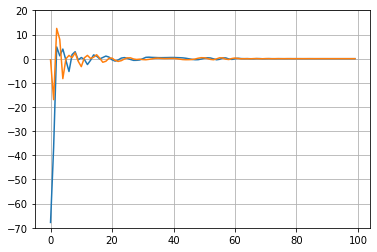

In [21]:
df_real[0][:100].plot(ylim=(-70,20))
df_imag[1][:100].plot(grid=True)

In [22]:
df_real[0][:12]

0    -67.776668
1    -36.899977
2      4.866761
3      1.181920
4      3.976777
5     -0.655133
6     -5.315858
7      1.689136
8      2.890359
9     -0.518525
10     0.473095
11    -0.315693
Name: 0, dtype: float64

In [23]:
df_real[0][11:22]

11   -0.315693
12   -2.433981
13   -0.682290
14    1.560316
15    1.047856
16   -0.097534
17    0.489940
18    1.079670
19    0.666746
20   -0.473553
21   -0.996223
Name: 0, dtype: float64

## Pulse compression and comparison with EchoView exported values

In [24]:
ds_beam

<xarray.Dataset>
Dimensions:                         (frequency: 2, ping_time: 88, quadrant: 4, range_bin: 25229)
Coordinates:
  * frequency                       (frequency) float32 70000.0 200000.0
  * ping_time                       (ping_time) float64 3.714e+09 ... 3.714e+09
    frequency_start                 (frequency) int64 ...
    frequency_end                   (frequency) int64 ...
  * quadrant                        (quadrant) int64 0 1 2 3
  * range_bin                       (range_bin) int64 0 1 2 ... 25227 25228
Data variables:
    channel_id                      (frequency) object ...
    beamwidth_receive_alongship     (frequency) float32 ...
    beamwidth_receive_athwartship   (frequency) float32 ...
    beamwidth_transmit_alongship    (frequency) float32 ...
    beamwidth_transmit_athwartship  (frequency) float32 ...
    beam_direction_x                (frequency) float32 ...
    beam_direction_y                (frequency) float32 ...
    beam_direction_z                (frequency) float32 ...
    angle_offset_alongship          (frequency) float32 ...
    angle_offset_athwartship        (frequency) float32 ...
    angle_sensitivity_alongship     (frequency) float32 ...
    angle_sensitivity_athwartship   (frequency) float32 ...
    equivalent_beam_angle           (frequency) float32 ...
    gain_correction                 (frequency) float32 ...
    sample_interval                 (frequency) float32 ...
    transmit_bandwidth              (frequency) float32 ...
    transmit_duration_nominal       (frequency) float32 ...
    transmit_power                  (frequency) float32 ...
    transducer_offset_x             (frequency) float32 ...
    transducer_offset_y             (frequency) float32 ...
    transducer_offset_z             (frequency) float32 ...
    slope                           (frequency, ping_time) float64 ...
    backscatter_r                   (frequency, quadrant, ping_time, range_bin) float32 ...
    backscatter_i                   (frequency, quadrant, ping_time, range_bin) float32 ...
    gpt_software_version            (frequency) object ...
    sa_correction                   (frequency) float64 ...

In [25]:
ds_env = xr.open_dataset(ek80_raw_path[:-4]+'.nc', group='Environment')

In [30]:
ds_vend = xr.open_dataset(ek80_raw_path[:-4]+'.nc', group='Vendor')

In [36]:
ds_beam.gain_correction

<xarray.DataArray 'gain_correction' (frequency: 2)>
array([27., 27.], dtype=float32)
Coordinates:
  * frequency        (frequency) float32 70000.0 200000.0
    frequency_start  (frequency) int64 ...
    frequency_end    (frequency) int64 ...
Attributes:
    long_name:  Gain correction
    units:      dB

In [32]:
ds_beam.gain_correction

<xarray.DataArray 'gain_correction' (frequency: 2)>
array([27., 27.], dtype=float32)
Coordinates:
  * frequency        (frequency) float32 70000.0 200000.0
    frequency_start  (frequency) int64 ...
    frequency_end    (frequency) int64 ...
Attributes:
    long_name:  Gain correction
    units:      dB

In [34]:
ds_beam.gain_correction.sel(frequency=70000).values

array(27., dtype=float32)

In [28]:
e_data = EchoData(ek80_raw_path[:-4]+'.nc')
e_data.calc_transmit_signal()
e_data.pulse_compression()

Let's look at just the 70 kHz channel first.

In [ ]:
# Length of generated transmit signal
len_tx_sig = e_data.ytx[0].size
len_tx_sig

In [ ]:
# Check size of pulse-compressed output
e_data.backscatter_compressed[0].shape

In [ ]:
# Checcck size of the received data, we know channel 0 is the 70 kHz channel
ds_beam.backscatter_r.sel(frequency=70000).dropna('range_bin').shape

We can see that the length along `range_bin` of the pulse compressed output is longer than the length of the backscatter signal. This is because for convolution the length of the output $L_{out}$ is related to the lengths of the input signals $L_{bscat}$ and $L_{tx}$ by $L_{out} = L_{bscat} + L_{tx} -1$.

This means that we should shift the pulse-compressed output _forward_ by $L_{tx}-1$ sample points to get to the right timing on the received signal $L_{bscat}$.

We next check how the pulse compressed outputs compare with exported values from EchoView. We first guess that the EchoView outputs are the mean of pulse-compressed values from all four quadrants.

In [ ]:
backscatter_compressed_ch0_mean = e_data.backscatter_compressed[0].mean(axis=0)

In [ ]:
plt.plot(backscatter_compressed_ch0_mean[0].real, label='real')
plt.plot(backscatter_compressed_ch0_mean[0].imag, label='imag')
plt.legend(fontsize=12)
plt.xlim(0,320)
plt.grid()
plt.show()

Now we shift it forward by 126 samples and plot it at the same scale as EchoView outputs:

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,3.5),sharey=True, sharex=True)
ax[0].plot(backscatter_compressed_ch0_mean[0][126:227].real, label='real')
ax[0].plot(backscatter_compressed_ch0_mean[0][126:227].imag, label='imag')
ax[0].legend(fontsize=14)
ax[0].set_title('Echopype', fontsize=14)
ax[0].grid()

df_real[0][:100].plot(ax=ax[1], ylim=(-70,20))
df_imag[1][:100].plot(ax=ax[1], grid=True)
ax[0].set_title('EchoView', fontsize=14)

plt.show()

The shape looks very similar. But are the values similar too?

In [ ]:
backscatter_compressed_ch0_mean[0][126:137].real.values

In [ ]:
df_real[0][:12]

In [ ]:
df_cmp = pd.DataFrame({'echopype_real': backscatter_compressed_ch0_mean[0][126:137].real.values,
                       'EchoView_real': df_real[0][:11], 
                       'echopype_imag': backscatter_compressed_ch0_mean[0][126:137].imag.values,
                       'EchoView_imag': df_imag[1][:11]})
df_cmp

We can see that the values are similar but not identical.

Diving in the Matlab code (not shown here), we know that the outputs we have here from echopype are the same up to 1e-5 or so, which is most likely within numerical precision of the pulse compression procedure.

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,3.5),sharey=True, sharex=True)
ax.plot(backscatter_compressed_ch0_mean[0][126:227].real, label='echopype real', color=np.ones(3)*0.8, lw=5)
df_real[0][:100].plot(ax=ax, ylim=(-70,20), label='EchoView real', linestyle='--', lw=2, color='b')
ax.plot(backscatter_compressed_ch0_mean[0][126:227].imag, label='echopype imag', color=np.ones(3)*0.8, lw=5)
df_imag[1][:100].plot(ax=ax, grid=True, label='EchoView imag', linestyle='--', lw=2, color='r')
ax.legend(fontsize=14, loc='lower right', bbox_to_anchor=[1.4,0.4])
ax.set_xlabel('Sample number', fontsize=14)
ax.set_ylabel('Output from\npulse compression', fontsize=14)
ax.grid()
ax.set_xlim(0,30)
ax.set_ylim(-20,20)

plt.show()